# Import stuff

In [1]:
import numpy as np
import pandas as pd
import time, sys 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.circuit import Parameter
from copy import deepcopy
from math import pi
from qiskit.tools.visualization import plot_state_city, plot_histogram
from qiskit.quantum_info import state_fidelity

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

from qiskit.providers.ibmq import IBMQ
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.monitor import job_monitor

# IBMQ Register/Device

In [2]:
ibmq_provider = IBMQ.load_account()

ibmq_simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
ibmq_device = ibmq_provider.get_backend('ibmq_burlington')

backend_IBMQ = ibmq_provider.get_backend('ibmq_burlington')
properties = backend_IBMQ.properties()
noise_model = NoiseModel.from_backend(properties)
coupling_map = backend_IBMQ.configuration().coupling_map
basis_gates = noise_model.basis_gates

# Define stuff

In [3]:
theta = Parameter('theta')

#====================================================================================

def output_fidelity(F_in):
    """ Returns output fidelity of BBPSSW protocol.
    
    Keyword arguments:
    F_in -- input fidelity
    """
    F_out = (np.square(F_in) + np.square(1-F_in)/9) \
            / (np.square(F_in) + 2*F_in*(1-F_in)/3 + 5*np.square(1-F_in)/9)
 
    return F_out

#====================================================================================

phi_plus = np.array([1, 0, 0, 1])/np.sqrt(2)   # | Phi^+ >
phi_minus = np.array([1, 0, 0, -1])/np.sqrt(2) # | Phi^- >
psi_plus = np.array([0, 1, 1, 0])/np.sqrt(2)   # | Psi^+ >
psi_minus = np.array([0, 1, -1, 0])/np.sqrt(2) # | Psi^- >

#====================================================================================

def Werner_state(F):
    """Returns Werner state of fidelity F.
    
    Keyword arguments:
    F -- fidelity of Werner state, range [0, 1]
    """
    if F < 0 or F > 1:
        raise Exception('Fidelity must be between 0 and 1.')
    
    state = F*np.outer(psi_minus, psi_minus.conj().T) \
            + (1 - F)/3*(np.outer(phi_plus, phi_plus.conj().T) \
                        + np.outer(phi_minus, phi_minus.conj().T) \
                        + np.outer(psi_plus, psi_plus.conj().T))
    
    return state

#====================================================================================

def F_to_theta(F):
    """Returns the angle theta corresponding to an input fidelity F.
    
    Keyword arguments:
    F -- fidelity between 0 and 1
    """
    if F < 0 or F > 1:
        raise Exception('Fidelity must be between 0 and 1.')
    else:
        theta = np.arcsin(2*F - 1)
    
    return theta

#====================================================================================

def bilateral_rotation(circuit, qubits, rot_idx):
    """Adds a bilateral rotation to a quantum circuit.
    
    Keyword arguments:
    circuit --  quantum circuit to which the rotations are added
    qubits -- alist of qubits, each of which is rotated
    rot_idx -- integer that numbers the rotations from the set of all rotations, ranges from 0 to 11
    """
    for qubit in qubits:
        if rot_idx == 0:
            pass
        
        elif rot_idx == 1:
            circuit.rx(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 2:
            circuit.ry(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            
        elif rot_idx == 3:
            circuit.rz(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            
        elif rot_idx == 4:
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            
        elif rot_idx == 5:
            circuit.ry(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            
        elif rot_idx == 6:
            circuit.rz(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 7:
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 8:
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            
        elif rot_idx == 9:
            circuit.ry(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            
        elif rot_idx == 10:
            circuit.rz(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 11:
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        else:
            raise Exception('Input argument rot_idx has to be an integer between 0 and 11.')
            
#====================================================================================

def purification_shots(job_results):
    """ Keep counts for successful purifications and return corresponding result.
    
    Keyword arguments:
    job_results -- execution results
    
    Returns:
    conditional_results -- results without unsuccessful shots
    """
    # Copy original results
    conditional_results = deepcopy(job_results)
    
    for ii,_ in enumerate(job_results.results):
        counts = job_results.get_counts(ii)
        conditional_counts = {}
        
        # Keep counts of successful purifications
        for result, count in counts.items():
            target_measurement = result.split(' ')[0]
            control_measurement = result.split(' ')[1]

            if target_measurement in ('00', '11'):
                if control_measurement in conditional_counts:
                    conditional_counts[control_measurement] = conditional_counts[control_measurement] + count
                else:
                    conditional_counts[control_measurement] = count
        
        # Adapt the properties of conditional_results accordingly
        conditional_results.results[ii].data.counts \
            = conditional_results.results[ii].data.counts.from_dict(conditional_counts)
        conditional_results.results[ii].header.clbit_labels = conditional_results.results[ii].header.clbit_labels[0:2]
        conditional_results.results[ii].header.creg_sizes = [conditional_results.results[ii].header.creg_sizes[0]]
        conditional_results.results[ii].header.memory_slots = 2
            
    return conditional_results

#====================================================================================

def job_dictionary(circuits, job):
    """ Returns dictionary.
    
    Keyword arguments:
    circuits -- list of quantum circuits
    job -- execution job, should correspond to execution of keyword argument 'circuits'
    """
    job_dict = {}
    job_dict["circuits"] = circuits
    job_dict["job"] = job
    
    return job_dict

#====================================================================================

def rho_from_dict(job_dict, cond_tomo):
    """ Returns a reconstructed density matrix using quantum state tomography.
    
    Keyword arguments:
    job_dict -- dictionary containing execution job and corresponding quantum circuits
    cond_tomo -- boolean that indicates whether conditional tomography is being performed (cond_tomo=True)
    
    Returns:
    rho_fit -- reconstructed density matrix
    """
    if cond_tomo:
        # Conditional quantum state tomography
        conditional_results = purification_shots(job_dict["job"].result())
        rho_fit = StateTomographyFitter(conditional_results, job_dict["circuits"]).fit()
    else:
        # Regular quantum state tomography
        rho_fit = StateTomographyFitter(job_dict["job"].result(), job_dict["circuits"]).fit()
    
    return rho_fit

#====================================================================================

def execute_purification(F_in, index, backend, shots, noise_model=None, coupling_map=None, basis_gates=None):
    """ Execute entire BBPSSW protocol on a target backend.
    
    Keyword arguments:
    F_in -- input fidelity
    index -- integer between 0 and 11, defines bilateral rotation
    backend -- backend to execute circuits
    shots -- number of shots per execution
    noise_model -- noise model for simulation of real device (required for noisy simulation)
    coupling_map -- list that specifies the qubit couplings (required for noisy simulation)
    basis_gates -- set of basis gates on real device (required for noisy simulation)
    
    Returns:
    job_dict -- dictionary containing execution job and tomography circuits
    """
    # Create experiment circuit and corresponding tomography circuits
    experiment_circ = experiment_circuit(index)
    tomography_circs, ancilla_tomography_circs = conditional_tomography_circuits(experiment_circ)
    
    # Execute tomography circuits on simulator (w/ noise parameters) or real device (w/o noise parameters)
    if backend.configuration().simulator == True:
        job = execute(ancilla_tomography_circs, backend, shots=shots,
                      noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates,
                      parameter_binds=[{theta: F_to_theta(F_in)}])
    else:
        job = execute(ancilla_tomography_circs, backend, shots=shots,
                      parameter_binds=[{theta: F_to_theta(F_in)}])
    
    # Construct job dictionary
    job_dict = job_dictionary(tomography_circs, job)
        
    return job_dict

#====================================================================================

def experiment_circuit(index):
    """ Returns experiment circuit corresponding to an index.
    
    Keyword arguments:
    index -- integer between 0 and 11
    
    Returns:
    experiment_circ -- quantum circuit
    """
    if index < 0 or index > 11:
        raise Exception("Index for bilateral rotation exceeds range of possible values.")
        
    # Create twirl circuit from the bilateral rotations
    twirl_circ = QuantumCircuit(qr)
    bilateral_rotation(twirl_circ, control_qubits, index)
    bilateral_rotation(twirl_circ, target_qubits, index)
    
    experiment_circ = source_circ + twirl_circ + purification_circ
    
    return experiment_circ

#====================================================================================

def ancilla_circuit(quantum_circuit, qubits):
    """ Return an ancilla circuit that includes additional measurements.
    
    Keyword arguments:
    quantum_circuit -- single quantum circuit
    qubits -- list of qubits to be measured
    
    Returns:
    ancilla_circ -- ancilla quantum circuit including measurement of qubits
    """
    # Copy original circuit
    ancilla_circ = deepcopy(quantum_circuit)
    
    # Add classical register
    cr = ClassicalRegister(len(qubits))
    ancilla_circ.add_register(cr)
    
    return ancilla_circ

#====================================================================================

def conditional_tomography_circuits(quantum_circuit):
    """ Returns all tomography circuits for conditional quantum state tomography. 
    
    Keyword arguments:
    quantum_circuit -- single quantum circuit
    
    Returns:
    tomography_circs -- tomography circuits for quantum circuit
    ancilla_tomography_circs -- ancilla tomography circuits with additional measurements on target qubits
    """
    # Create ancilla circuit
    ancilla_circ = ancilla_circuit(quantum_circuit, target_qubits)
    
    # Create tomography circuits
    tomography_circs = state_tomography_circuits(quantum_circuit, control_qubits)
    ancilla_tomography_circs = state_tomography_circuits(ancilla_circ, control_qubits)
     
    for i in range(0, 9):
        ancilla_tomography_circs[i].measure(target_qubits[0], 2)
        ancilla_tomography_circs[i].measure(target_qubits[1], 3)
    
    return tomography_circs, ancilla_tomography_circs

#====================================================================================


# Circuit stuff

## Source circuit

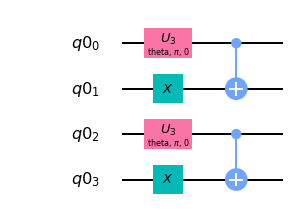

In [4]:
qr = QuantumRegister(4)
source_circ = QuantumCircuit(qr)

source_circ.x(qr[1]);
source_circ.u3(theta, pi, 0, qr[0]);
source_circ.cx(qr[0], qr[1]);
source_circ.x(qr[3])
source_circ.u3(theta, pi , 0, qr[2])
source_circ.cx(qr[2], qr[3]);

control_qubits = [qr[0], qr[1]]
target_qubits = [qr[2], qr[3]]

all_qubits = [qr[0], qr[1], qr[2], qr[3]]

source_circ.draw(output='mpl')

## Twirl circuit

In [5]:
twirl_circ = QuantumCircuit(qr)

# Create a random integer between 0 and 11
random_idx = np.random.randint(12)

# Add a random bilateral rotation to the circuit, applied to qubits 0 and 1 (control qubits)
bilateral_rotation(twirl_circ, control_qubits, random_idx)

# Add a random bilateral rotation to the circuit, applied to qubits 2 and 3 (target qubits)
bilateral_rotation(twirl_circ, target_qubits, random_idx)

#twirl_circ.draw(output='mpl')

## Purification circuit

In [6]:
purification_circ = QuantumCircuit(qr)

# Implement a Pauli-Y gate on Alice's control qubit
purification_circ.y(control_qubits[0])

# Implement a Pauli-Y gate on Alice's target qubit
purification_circ.y(target_qubits[0]);

purification_circ.cx(control_qubits[0], target_qubits[0])
purification_circ.cx(control_qubits[1], target_qubits[1])
    
#purification_circ.draw(output='mpl')

## Final circuit

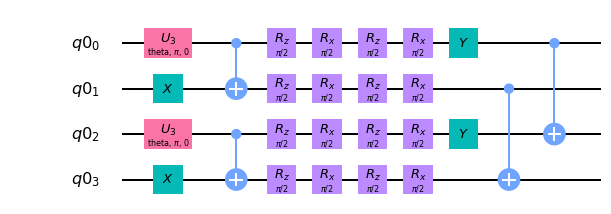

In [7]:
experiment_circ = source_circ + twirl_circ + purification_circ

experiment_circ.draw(output='mpl')

## Tomography circuit

In [8]:
tomography_circs = state_tomography_circuits(experiment_circ, control_qubits)

#tomography_circs[0].draw(output='mpl')

## Ancilla circuit

In [9]:
#ancilla_circ = deepcopy(experiment_circ)
cr = ClassicalRegister(2)

#ancilla_circ.add_register(cr)

#print(cr)

#ancilla_tomography_circs = state_tomography_circuits(ancilla_circ, control_qubits)

#for i in range(0, 9):
 #   ancilla_tomography_circs[i].measure(target_qubits[0], cr[0])
  #  ancilla_tomography_circs[i].measure(target_qubits[1], cr[1])

#ancilla_tomography_circs[0].draw(output='mpl')

(<qiskit.extensions.standard.u3.U3Gate object at 0x0000026E1D221BB0>, [Qubit(QuantumRegister(4, 'q0'), 0)], [])
[Qubit(QuantumRegister(4, 'q0'), 2), Qubit(QuantumRegister(4, 'q0'), 3)]


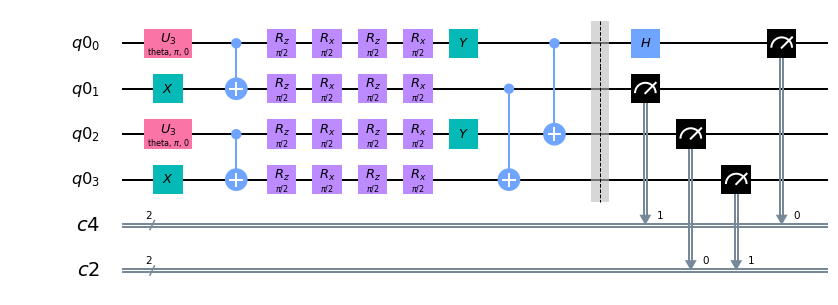

In [10]:
banen = conditional_tomography_circuits(experiment_circ)[1]
crx = ancilla_circuit(experiment_circ, target_qubits)[1]

print(crx)
print(target_qubits)
banen[2].draw(output='mpl')

# Error mitigation

In [11]:
exp_circ = experiment_circuit(0) #can be any number as it doesn't matter here
con_circ = conditional_tomography_circuits(exp_circ)[0]

clz, state_labels = complete_meas_cal(qr = con_circ[8].qregs[0], circlabel = 'measerrormitcal')
cal_circuit = [clz[0], clz[1], clz[2], clz[3]]

cal_job = execute(cal_circuit,backend = ibmq_device,shots = 4096,optimization_level = 0,)
job_monitor(cal_job)
calres = cal_job.result()

Job Status: job has successfully run


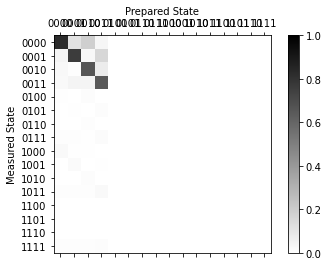

In [12]:
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

In [13]:
bits = ['0000', '1000', '0100', '1100', 
        '0001', '1001', '0101', '1101',
        '0010', '1010', '0110', '1110', 
        '0011', '1011', '0111', '1111']

counts = [0,0,0,0]
for i in range(4):
    counts[i] = calres.get_counts(cal_circuit[i])
    for bit in bits:
        if bit not in counts[i]:
            counts[i][bit] = 0

m_IZ = [0,0,0,0]
m_ZI = [0,0,0,0]
m_ZZ = [0,0,0,0]
for i in range(4):
    for num, bit in enumerate(bits):
        if num % 4 == 0 or num % 4 == 1:
            m_IZ[i] += float(counts[i][bit]) / 8192
        if num % 4 == 2 or num % 4 == 3:
            m_IZ[i] -= float(counts[i][bit]) / 8192
        if num % 4 == 0 or num % 4 == 2:
            m_ZI[i] += float(counts[i][bit]) / 8192
        if num % 4 == 1 or num % 4 == 3:
            m_ZI[i] -= float(counts[i][bit]) / 8192
        if num % 4 == 0 or num % 4 == 3:
            m_ZZ[i] += float(counts[i][bit]) / 8192
        if num % 4 == 1 or num % 4 == 2:
            m_ZZ[i] -= float(counts[i][bit]) / 8192

M = [[1,  1,  1,  1], 
     [1,  1, -1, -1], 
     [1, -1,  1, -1], 
     [1, -1, -1,  1]]
Minv = np.linalg.inv(M)

beta_IZ = np.dot(Minv, m_IZ)
beta_ZI = np.dot(Minv, m_ZI)
beta_ZZ = np.dot(Minv, m_ZZ)

b_vec = [beta_IZ[0], beta_ZI[0], beta_ZZ[0]]
B = [beta_IZ[1:], beta_ZI[1:], beta_ZZ[1:]]
Binv = np.linalg.inv(B)

print(B)
print(b_vec)

[array([ 0.00964355,  0.00085449, -0.00061035]), array([-0.00134277,  0.00048828, -0.00280762]), array([ 0.00622559,  0.00097656, -0.00280762])]
[0.4627685546875, 0.4501953125, 0.438720703125]


## Choose fidelities (in array format)

In [14]:
input_fidelities_all = [0.9]
N_all = 5

# Simulation

In [15]:
input_fidelities = input_fidelities_all
N = N_all

# Empty list for storing all output fidelities
output_fidelities = []

for jj, fidelity in enumerate(input_fidelities):
    fitted_states = []
    
    
    for ii in range(N):
        # Create circuits, execute circuits on simulator, reconstruct density matrix of control qubits
        random_idx = np.random.randint(12)
        job_dict = execute_purification(fidelity, random_idx, ibmq_simulator, shots=8192)
        rho_fit = rho_from_dict(job_dict, cond_tomo=True)
        fitted_states.append(rho_fit)
        
        if ((ii+1)/10).is_integer() or ii == 0:
            print(str(ii+1) + "/" + str(N*len(input_fidelities)) + " simulation runs done. Out of " + str(jj+1) + "/" + str(len(input_fidelities)) + " input fidelities.")
    
        
    # Calculate average density matrix
    rho_average = sum(fitted_states)/N
    
    # Calculate fidelity towards Phi^+ and add fidelity to list
    output_fidelities.append(state_fidelity(rho_average, phi_plus))
    
    

1/5 simulation runs done. Out of 1/1 input fidelities.


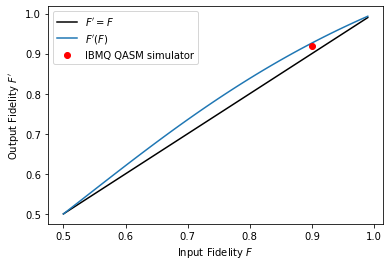

In [16]:
F_in = np.arange(0.5, 1.0, 0.01)
plt.plot(F_in, F_in, 'k', label = "$F' = F$")
plt.plot(F_in, output_fidelity(F_in), label = "$F'(F)$")
plt.plot(input_fidelities, output_fidelities, 'ro', label='IBMQ QASM simulator')
plt.legend()
plt.xlabel('Input Fidelity $F$')
plt.ylabel("Output Fidelity $F'$");


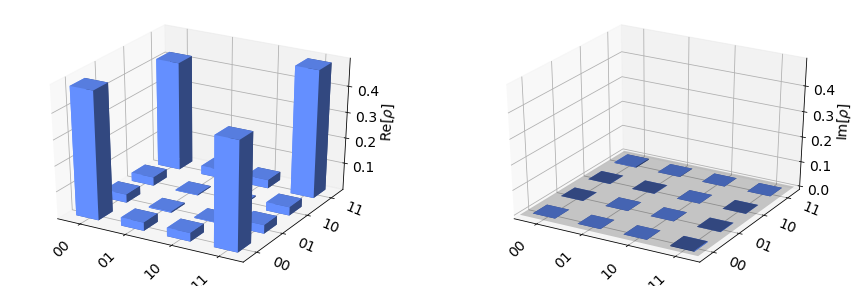

In [17]:
plot_state_city(rho_average)

## With noise

In [18]:
input_fidelities_noise = input_fidelities_all
N = N_all


# Empty list for storing all output fidelities
output_fidelities_noise = []

for jj, fidelity in enumerate(input_fidelities_noise):
    fitted_states = []
    
    
    for ii in range(N):
        # Create circuits, execute circuits on simulator, reconstruct density matrix of control qubits
        random_idx = np.random.randint(12)
        job_dict = execute_purification(fidelity, random_idx, ibmq_simulator, shots=512, 
                                        noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
        rho_fit = rho_from_dict(job_dict, cond_tomo=True)
        fitted_states.append(rho_fit)
        
        if ((ii+1)/10).is_integer() or ii == 0:
            print(str(ii+1) + "/" + str(N*len(input_fidelities_noise)) + " simulation runs done. Out of " + str(jj+1) + "/" + str(len(input_fidelities_noise)) + " input fidelities.")
                
        #print(str(jj+ii+1) + "/" + str(N*len(input_fidelities)) + " simulation runs done.")
    
    # Calculate average density matrix
    rho_average = sum(fitted_states)/N
    
    # Calculate fidelity towards Phi^+ and add fidelity to list
    output_fidelities_noise.append(state_fidelity(rho_average, phi_plus))
    
    

1/5 simulation runs done. Out of 1/1 input fidelities.


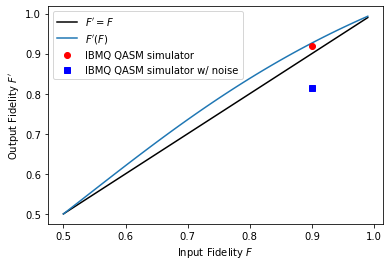

In [19]:
F_in = np.arange(0.5, 1.0, 0.01)
plt.plot(F_in, F_in, 'k', label = "$F' = F$")
plt.plot(F_in, output_fidelity(F_in), label = "$F'(F)$")
plt.plot(input_fidelities, output_fidelities, 'ro', label='IBMQ QASM simulator')
plt.plot(input_fidelities_noise, output_fidelities_noise, 'bs', label='IBMQ QASM simulator w/ noise')
plt.legend()
plt.xlabel('Input Fidelity $F$')
plt.ylabel("Output Fidelity $F'$");


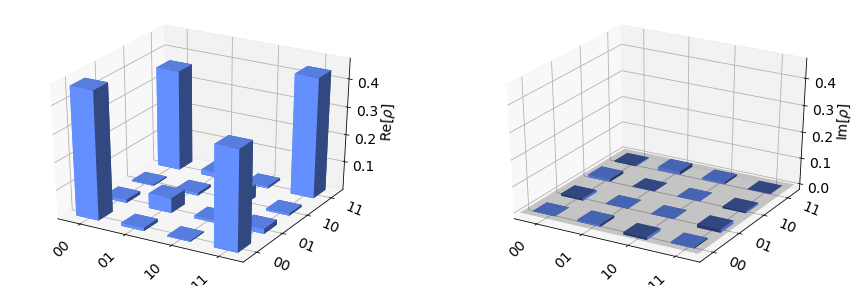

In [20]:
plot_state_city(rho_average)

## Device

In [21]:
input_fidelities_dev = input_fidelities_all
N = N_all

list_results = [] #list to store all the jobs (for now works only with a single input fidelity)

# Empty list for storing all output fidelities
output_fidelities_dev = []

for jj, fidelity in enumerate(input_fidelities_dev):
    fitted_states = []
    
    for ii in range(N):
        # Create circuits, execute circuits on simulator, reconstruct density matrix of control qubits
        random_idx = np.random.randint(12)
        job_dict = execute_purification(fidelity, random_idx, ibmq_device, shots=512)
        rho_fit = rho_from_dict(job_dict, cond_tomo=True)
        fitted_states.append(rho_fit)
        
        list_results.append(job_dict)
        
        if ((ii+1)/5).is_integer() or ii == 0:
            print(str(ii+1) + "/" + str(N*len(input_fidelities_dev)) + " runs done. Out of " + str(jj+1) + "/" + str(len(input_fidelities_dev)) + " input fidelities.")
        
    # Calculate average density matrix
    rho_average = sum(fitted_states)/N
    
    # Calculate fidelity towards Phi^+ and add fidelity to list
    output_fidelities_dev.append(state_fidelity(rho_average, phi_plus))
    

1/5 runs done. Out of 1/1 input fidelities.
5/5 runs done. Out of 1/1 input fidelities.


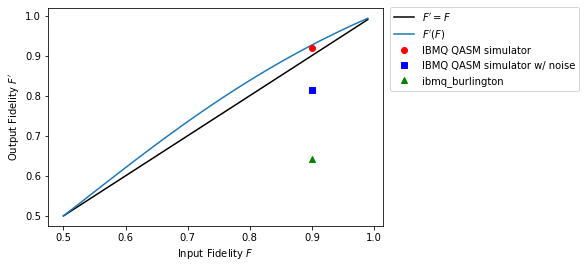

In [22]:
F_in = np.arange(0.5, 1.0, 0.01)
plt.plot(F_in, F_in, 'k', label = "$F' = F$")
plt.plot(F_in, output_fidelity(F_in), label = "$F'(F)$")
plt.plot(input_fidelities, output_fidelities, 'ro', label='IBMQ QASM simulator')
plt.plot(input_fidelities_noise, output_fidelities_noise, 'bs', label='IBMQ QASM simulator w/ noise')
plt.plot(input_fidelities_dev, output_fidelities_dev, 'g^', label=backend_IBMQ.name())
plt.legend(bbox_to_anchor=(1.6,1.03), loc="upper right")
plt.xlabel('Input Fidelity $F$')
plt.ylabel("Output Fidelity $F'$");


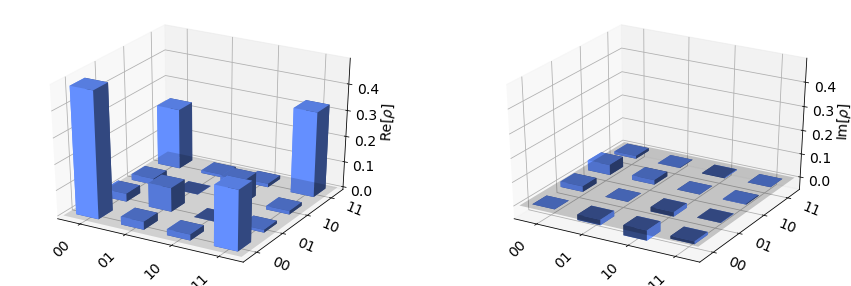

In [23]:
plot_state_city(rho_average)

## Don't look beyond here --------------------------------------------------------------------------------
It is all rubbish... But everything above works!

In [ ]:
counts = job_dict["job"].result()
#counts_pure = purification_shots(job_dict["job"].result())

counts_mit = meas_filter.apply(counts)

#counts_pure_mit = purification_shots(counts_mit)

#print(counts)
#print("next:")
#print(counts_mit)

#plot_histogram(counts_mit.get_counts())

In [ ]:
#print(meas_fitter.cal_matrix[0])

In [ ]:
#pure_jobs = purification_shots(job_dict["job"].result())

#print(pure_jobs)

In [ ]:
#plot_histogram(pure_jobs.get_counts(0))

In [ ]:
testding = list_results[2]["job"].result().get_counts(4)

print(testding)

counts_mit = meas_filter.apply(testding)

print(counts_mit)

In [ ]:
plot_histogram(testding)

In [ ]:
calres.get_counts(0)

In [ ]:
testding.keys()

In [ ]:
testding['1001'] = testding.pop('10 01')
testding['1011'] = testding.pop('10 11')
testding['0010'] = testding.pop('00 10')
testding['1010'] = testding.pop('10 10')
testding['0100'] = testding.pop('01 00')
testding['1111'] = testding.pop('11 11')
testding['0011'] = testding.pop('00 11')
testding['0000'] = testding.pop('00 00')
testding['1101'] = testding.pop('11 01')
testding['0111'] = testding.pop('01 11')
testding['0001'] = testding.pop('00 01')
testding['0110'] = testding.pop('01 10')
testding['1000'] = testding.pop('10 00')
testding['1110'] = testding.pop('11 10')
testding['1100'] = testding.pop('11 00')
testding['0101'] = testding.pop('01 01')


In [ ]:
print(testding)

In [ ]:
testding_mit = meas_filter.apply(testding)

In [ ]:
plot_histogram([testding_mit, testding], legend = ['mit', 'raw'])

In [ ]:
job_list_mit = []
for a in range(5):
    job_list_mit.append([])


for j in range(5):
    for i in range(9):
        
        job_list = list_results[j]["job"].result().get_counts(i)
        
        job_list['1001'] = job_list.pop('10 01')
        job_list['1011'] = job_list.pop('10 11')
        job_list['0010'] = job_list.pop('00 10')
        job_list['1010'] = job_list.pop('10 10')
        job_list['0100'] = job_list.pop('01 00')
        job_list['1111'] = job_list.pop('11 11')
        job_list['0011'] = job_list.pop('00 11')
        job_list['0000'] = job_list.pop('00 00')
        job_list['1101'] = job_list.pop('11 01')
        job_list['0111'] = job_list.pop('01 11')
        job_list['0001'] = job_list.pop('00 01')
        job_list['0110'] = job_list.pop('01 10')
        job_list['1000'] = job_list.pop('10 00')
        job_list['1110'] = job_list.pop('11 10')
        job_list['1100'] = job_list.pop('11 00')
        job_list['0101'] = job_list.pop('01 01')
        
      
        job_list_mit[j].append(meas_filter.apply(job_list))

In [ ]:
job_list_mit[0][0]

In [ ]:
double_list_mit = []
for a in range(5):
    double_list_mit.append([])

for j in range(5):
    for i in range(9):
        d = {}
        
        print(j)
        print(i)

        d["00"] = job_list_mit[j][i].get("0000") + job_list_mit[j][i].get("1100")
        d["01"] = job_list_mit[j][i].get("0001") + job_list_mit[j][i].get("1101")
        d["10"] = job_list_mit[j][i].get("0010") + job_list_mit[j][i].get("1110")
        d["11"] = job_list_mit[j][i].get("0011") + job_list_mit[j][i].get("1111")
        
        double_list_mit[j].append(d)

In [ ]:
paulis = [('X','X','Z','Z'),('Y','X','Z','Z'),('Z','X','Z','Z'),
          ('X','Y','Z','Z'),('Y','Y','Z','Z'),('Z','Y','Z','Z'),
          ('X','Z','Z','Z'),('Y','Z','Z','Z'),('Z','Z','Z','Z')]

basis = ['XX','YX','ZX',
         'XY','YY','ZY',
         'XZ','YZ','ZZ']

state ={}

for bas in basis:
    state.update({bas: {'00': 0, '01': 0, '10': 0, '11': 0}})
state_df = pd.DataFrame(data=[state,state,state,state])

for pauli in paulis:
    for bit in bits:
         if bit not in rho_average.data[pauli]:
             rho_average.data[pauli][bit] = 0

In [ ]:
# defining the matrices to construct the density matrices
I_matrix = np.matrix('1, 0; 0, 1')
X_matrix = np.matrix('0, 1; 1, 0')
Y_matrix = np.matrix('0, 0-1j; 0+1j, 0')
Z_matrix = np.matrix('1, 0; 0, -1')

Iden = np.kron(I_matrix,I_matrix)

IXPaul = np.kron(I_matrix,X_matrix)
IYPaul = np.kron(I_matrix,Y_matrix)
IZPaul = np.kron(I_matrix,Z_matrix)
XIPaul = np.kron(X_matrix,I_matrix)
YIPaul = np.kron(Y_matrix,I_matrix)
ZIPaul = np.kron(Z_matrix,I_matrix)

XXPaul = np.kron(X_matrix,X_matrix)
XYPaul = np.kron(X_matrix,Y_matrix)
XZPaul = np.kron(X_matrix,Z_matrix)

YXPaul = np.kron(Y_matrix,X_matrix)
YYPaul = np.kron(Y_matrix,Y_matrix)
YZPaul = np.kron(Y_matrix,Z_matrix)

ZXPaul = np.kron(Z_matrix,X_matrix)
ZYPaul = np.kron(Z_matrix,Y_matrix)
ZZPaul = np.kron(Z_matrix,Z_matrix)

In [ ]:
# there are 4 density matrices to calculate for each of sim, sim_noise and dev

# XX, XY, XZ etc are 9 total r_xx etc terms to calculate
r_exp = np.zeros(9)
# there are three IX type terms and each can be calculated three ways (from XX, YX, ZX for IX)
r_IP = np.zeros(9)
r_PI = np.zeros(9)
r_IPavg = np.zeros(3)
r_PIavg = np.zeros(3)

m = np.zeros((9,3))
r_corr = np.zeros((9,3))
r_IPavg_corr = np.zeros(3)
r_PIavg_corr = np.zeros(3)

rho=[0,0,0,0]

rhof = [0,0,0,0]
for i in range(4):
    for j in range(9):
        r_exp[i,j] = (states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(-1) + states[basis[j]][i]['01']*(-1) + states[basis[j]][i]['11']*1)/(states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*1)
        r_IP[i,j] = (states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(-1) + states[basis[j]][i]['11']*(-1))/(states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*1)
        r_PI[i,j] = (states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(-1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*(-1))/(states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*1)
            
for i in range(4):
    for j in range(3):
             r_IPavg[i,j]  = (r_IP[i,j] + r_IP[i,j+3] + r_IP[i,j+6])/3
             r_PIavg[i,j] = (r_PI[i,3*j] + r_PI[i,3*j+1] + r_PI[i,3*j+2])/3
for i in range(4):
    rhof[i] = (1/4)*(Iden + r_exp[i,0]*XXPaul + r_exp[i,1]*XYPaul + r_exp[i,2]*XZPaul
                              + r_exp[i,3]*YXPaul + r_exp[i,4]*YYPaul + r_exp[i,5]*YZPaul
                              + r_exp[i,6]*ZXPaul + r_exp[i,7]*ZYPaul + r_exp[i,8]*ZZPaul
                              + r_IPavg[i,0]*IXPaul + r_PIavg[i,0]*XIPaul
                              + r_IPavg[i,1]*IYPaul + r_PIavg[i,1]*YIPaul
                              + r_IPavg[i,2]*IZPaul + r_PIavg[i,2]*ZIPaul)
    rho[stat] = rhof


In [ ]:
# performing corrections for readout error and storing result in another density matrix
for i in range(4):
    for num, bas in enumerate(basis):
        m[i,num,:] = [r_IP[i,num], r_PI[i, num], r_exp[i,num]]
        r_corr[i,num] = np.dot(Binv, np.subtract(m[i,num,:],b_vec))

rho_corr = [0,0,0,0]
for i in range(4):
    for j in range(3):
            r_IPavg_corr[i,j] = (r_corr[i,j][0] + r_corr[i,j+3][0] + r_corr[i,j+6][0])/3
            r_PIavg_corr[i,j] = (r_corr[i,3*j][1] + r_corr[i,3*j+1][1] + r_corr[i,3*j+2][1])/3

    rho_corr[i] = (1/4)*(Iden + r_corr[i,0][2]*XXPaul + r_corr[i,1][2]*XYPaul + r_corr[i,2][2]*XZPaul
                              + r_corr[i,3][2]*YXPaul + r_corr[i,4][2]*YYPaul + r_corr[i,5][2]*YZPaul
                              + r_corr[i,6][2]*ZXPaul + r_corr[i,7][2]*ZYPaul + r_corr[i,8][2]*ZZPaul
                              + r_IPavg_corr[i,0]*IXPaul + r_PIavg_corr[i,0]*XIPaul
                              + r_IPavg_corr[i,1]*IYPaul + r_PIavg_corr[i,1]*YIPaul
                              + r_IPavg_corr[i,2]*IZPaul + r_PIavg_corr[i,2]*ZIPaul)

rho[3] = rho_corr

for ind in range(4):
    rho[ind][1] = ZIPaul @ rho[ind][1] @ ZIPaul
    rho[ind][2] = XIPaul @ rho[ind][2] @ XIPaul
    rho[ind][3] = XIPaul @ IZPaul @ rho[ind][3] @ IZPaul @ XIPaul
    
# finding the average density matrix from the four possible outcomes
rho_avg = [0,0,0,0]
for i in range(4):
    rho_avg[i] = np.mean(np.array([rho[i][0], rho[i][1], rho[i][2], rho[i][3]]), axis=0)

In [ ]:
np.zeros(3)